In [1]:
import requests
import time
from time import sleep
from bs4 import BeautifulSoup

In [2]:
#找出魔鏡歌詞網中有列出的全部理想混蛋的歌的網址

link = []
#因為有的是專輯，所以有些有延伸，而其中有一首因為是翻唱所以不抓
for i in range(1, 21):
    if i == 9:
        link.append('https://mojim.com/twy219017x9x1.htm')
        link.append('https://mojim.com/twy219017x9x2.htm')
    elif i == 11:
        for j in range(1, 12):
            link.append(f'https://mojim.com/twy219017x{i}x{j}.htm')
    elif i == 18:
        for j in range(1, 11):
            link.append(f'https://mojim.com/twy219017x{i}x{j}.htm')
    elif i != 2:
        link.append(f'https://mojim.com/twy219017x{i}x1.htm')

In [3]:
head = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
}
for url in link:
    response = requests.get(url, headers=head)
    if response.status_code == 200:
        #print(f'{url} 請求成功！') #此網址打「url, '請求成功！'」也會正確 #註:因為確認都顯示成功，所以就不print了
        soup = BeautifulSoup(response.text, 'html.parser')
    #else:
        #print(f'{url} 請求失敗，狀態碼為 {response.status_code}。')

In [4]:
for url in link:  
    response = requests.get(url, headers=head)
    soup = BeautifulSoup(response.text, 'html.parser')
    tag_div = soup.find_all('div', {'id': 'fsZ', 'class': 'fsZ'})
    for div in tag_div:
        tag_dl = div.find_all('dl', {'id': 'fsZx1', 'class': 'fsZx1'})
        #print(tag_dl) #註:因為確認都抓到了，所以不print結果了

In [5]:
#存成csv檔
import csv

data = []
for url in link:
    response = requests.get(url, headers=head)
    soup = BeautifulSoup(response.text, 'html.parser')
    tag_div = soup.find_all('div', {'id': 'fsZ', 'class': 'fsZ'})
    for div in tag_div:
        tag_dl = div.find_all('dl', {'id': 'fsZx1', 'class': 'fsZx1'})
        for dl in tag_dl:
            #針對tag_dl做內部迴圈，.text.strip()將提取出來的文字內容刪除頭尾空格
            data.append([dt.text.strip() for dt in dl.find_all('dt')]) #歌名
            data.append([dd.text.strip() for dd in dl.find_all('dd')]) #歌詞

#打開csv檔，使用w模式開啟以便寫入資料，並確保每行資料寫入時都以一個空行分隔
with open('data.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile) #定義寫入器
    writer.writerow(['songs']) #寫入檔案的標頭(欄位名稱)
    writer.writerows(data) #將所有資料寫入檔案中 #一定要編碼，不然這行會錯誤

### 爬蟲完成，接下來進行斷詞

In [94]:
import pandas as pd
import jieba #使用jieba前要先pip install jieba，因為其它地方已經跑過了，這裡就不再跑一次了
import jieba.analyse
from collections import Counter

In [95]:
bestard = pd.read_csv('data.csv')
bestard.head()

,songs
0,行星
1,作詞：邱建豪作曲：邱建豪、郭哲成編曲：理想混蛋主唱：邱建豪沒有行李 沒有目的一個人旅行在無邊...
2,不是因為天氣晴朗才愛你
3,演唱：邱建豪作詞：邱建豪作曲：邱建豪編曲：理想混蛋不是因為天氣晴朗才愛你不是因為看見星星才想...
4,獨角仙的夢 (Kabutomushi's Dream)


In [96]:
#test jieba
document = ['理想混蛋超級好聽！']
for sentence in document:
    seg_list = jieba.cut(sentence) #cut斷詞後返回一個生成器(generator)
    print('/'.join(seg_list)) #以/區分斷詞，並用join串接字串

理想/混蛋/超級/好/聽/！


In [97]:
bestard['seg'] = '' #新增一欄
bestard.head()

,songs,seg
0,行星,
1,作詞：邱建豪作曲：邱建豪、郭哲成編曲：理想混蛋主唱：邱建豪沒有行李 沒有目的一個人旅行在無邊...,
2,不是因為天氣晴朗才愛你,
3,演唱：邱建豪作詞：邱建豪作曲：邱建豪編曲：理想混蛋不是因為天氣晴朗才愛你不是因為看見星星才想...,
4,獨角仙的夢 (Kabutomushi's Dream),


In [98]:
jieba.analyse.set_stop_words('stopwords.txt') #設置停用詞，這些詞在斷詞時會被忽略不計
index = 0
for documents in bestard['songs'].astype(str):
    seg_list = jieba.analyse.extract_tags(documents, 150) #數字表示保留前XX個關鍵詞
    #seg_list = jieba.lcut(documents) #不需要自訂停用詞檔，所以沒有忽略贅字的功能
    bestard['seg'].iloc[index] = seg_list #integer location-based indexing(iloc)可通過行列數字訪問數據 #等號兩邊位置不可互換
    index += 1 #更新index的值，指定下一筆資料要寫入哪一行

In [99]:
bestard['seg']

0                                                  [行星]
1     [一個, 遺忘, 發著光, 這樣, 安靜, 地被, 沒有, 一圈, 一如, 往常, 獨自盤,...
2                                      [因為, 天氣, 晴朗, 不是]
3     [因為, 天氣, 牽著, 走過, 盛開, 一樣, 喜歡, 不是, 水花, 一直, 大雨, 路...
4                              [獨角, Kabutomushi, Dream]
                            ...                        
73    [爆炸, 地球, 什麼, 我們, 還有, 時間, 實現, 再來, 一場, 華麗, 冒險, 瘋...
74                                                   []
75    [每個, 永遠屬, 你屬, 天氣, 我會, 每次, 靠近, 電影, 林孝謙, 遇見, 隨太陽...
76                                        [Easy, Peasy]
77    [Easy, peasy, lemon, squeezy, 姿勢, 帥氣, 狼狽, 十之, ...
Name: seg, Length: 78, dtype: object

In [100]:
bestard.to_csv("words.csv", index=False) #index=False表示不寫入行索引

In [101]:
type(bestard['seg'])

pandas.core.series.Series

In [102]:
#把所有字串用空格連接起來，而其中所有的斷詞會用空格分開
words_str = ' '.join(bestard['seg'].apply(lambda x: ' '.join(x)))

In [103]:
#Counter計算每個詞的出現次數
#split將words_str字串中的每個詞以空白分割成一個個單獨的字串，並返回一個由這些字串構成的列表
#keys會回傳所有斷詞
Counter(words_str.split()).keys()

dict_keys(['行星', '一個', '遺忘', '發著光', '這樣', '安靜', '地被', '沒有', '一圈', '一如', '往常', '獨自盤', '軌道', '圍繞', '不願', '遠離', '習慣', '裡遊戲', '成為', '我放棄', '時間', '轉過', '過了', '孤寂', '一季', '仰望', '無邊', '耗盡', '勇氣', '無人', '回應', '忘記', '溫熱', '喚醒', '無法觸', '那絕', '距離', '歌詞', '發現', '遠方', '這裡', '許有', '天時間', '願望', '殘響', '滿足', '直到', '定律', '影子', '靠近', '星球', '踱步', '沉睡', '投射', '混蛋', '埋葬', '歌唱', '指引', '一天', '光芒', '旅行', '一年', '身旁', '行李', '幻想', '清醒', '黑暗', '呼吸', '幸福', '理想', '未命名', '等待', '不能', 'Mojim', 'Bestards', 'END', '感謝', '動態', '留下', '回答', '目的', '忘我', '仍然', '提供', '因為', '天氣', '晴朗', '不是', '牽著', '走過', '盛開', '一樣', '喜歡', '水花', '一直', '大雨', '路口', '看見', '剛好', '沒有別', '腦海裡', '習擁', '什麼', '最合', '適其實', '常會', '我們', '樣子', '左邊', '牽著手', '還有', '其實', '這麼', '小狗', '想像', '星星', '小孩子', '右手', '角度', '很多', '演唱', '可能', '獨角', 'Kabutomushi', 'Dream', '劈開', '往前', '夏天', '風乾', '飛多遠', '一點', '綠色', '找回', '一角', '花園', '開鮮', '中睜開', '雙眼', '燈火炙烈', '鋼鐵飛', '鄉間', '翅膀', '水泥', '一座', '童年', '以前', '驕傲', '活著', '裡飛', '身體', '還殘留', '氣味', '高樓', '天際線', '尖銳', '開夕陽', '窗簾', '進光線'

In [104]:
show_key = pd.DataFrame(Counter(words_str.split()).keys()) #key將回傳斷詞並轉換成DataFrame形式
show_values = pd.DataFrame(Counter(words_str.split()).values()) #values取得所有出現次數並轉換成DataFrame形式

#合併DataFrame
result = pd.concat([show_key, show_values], axis=1) #axis=0表示按照行的方向進行合併，axis=1表示按照列的方向進行合併
result.columns = ['word', 'frequency']
result.head(10)

,word,frequency
0,行星,4
1,一個,15
2,遺忘,3
3,發著光,2
4,這樣,8
5,安靜,3
6,地被,2
7,沒有,3
8,一圈,2
9,一如,2


In [105]:
import plotly.express as px

px.bar(result, x='word', y='frequency', title='number of words')

### 斷詞完成，接下來進行文字雲

In [107]:
pip install wordcloud

     ------------------------------------ 153.3/153.3 kB 277.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [113]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

In [159]:
record = np.array(Image.open("唱片機.jpg")) #讀取圖片後將圖片轉換成NumPy陣列格式
font = "C:\Windows\Fonts\MSJH.TTC"#設定字體為微軟正黑體

In [160]:
type(result)

pandas.core.series.Series

In [161]:
#統計seg_list中每個元素出現的次數，並轉換成整數類型(因為原本的數據類型可能是浮點型，而WordCloud需要的是整數類型)
result = pd.value_counts(seg_list).astype(int)
#key是元素值(斷詞)轉換成字串，並算出現次數，最後轉換成字典
result_dict = {str(key): val for key, val in result.to_dict().items()}

In [162]:
#設定文字雲以及呈現

wordcloud = WordCloud(background_color = "white", font_path = font, mask = record)
wordcloud.generate_from_frequencies(result_dict)

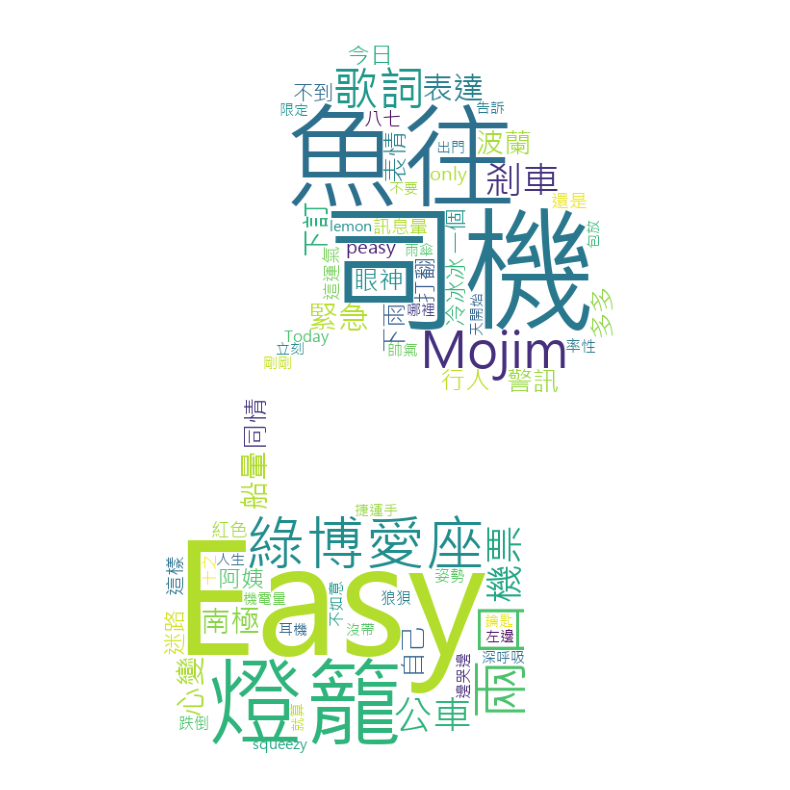

In [164]:
plt.figure(figsize=(10,10)) #圖片大小，寬高皆為10單位
plt.imshow(wordcloud) #顯示文字雲圖片
plt.axis("off") #關閉座標軸
plt.show() #顯示圖片